In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define image dimensions and parameters
img_height = 224
img_width = 224
batch_size = 32
num_classes = 4

# Define path to your dataset
data_dir = 'Image_Data'

# Prepare the ImageDataGenerator for loading images
datagen = ImageDataGenerator(rescale=1./255)

# Load all data and labels
all_data = []
all_labels = []

categories = ["Blue_fire","Green_fire","Orange_fire","White_fire"]

for category in categories:
    category_path = os.path.join(data_dir, category)
    
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        all_data.append(img_array)
        all_labels.append(category)


# Convert lists to numpy arrays
all_data = np.array(all_data)
#all_labels = np.array(all_labels)

In [3]:
# Convert labels to one-hot encoding
label_map = {name: index for index, name in enumerate(categories)}
all_labels = np.array([label_map[label] for label in all_labels])
all_labels = tf.keras.utils.to_categorical(all_labels, num_classes)

In [4]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

# # Convert labels to one-hot encoding
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess the testing set
test_datagen = ImageDataGenerator()

In [5]:
# Load and preprocess training and testing data
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

# Load the MobileNetV2 model, excluding the top layers
#base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
#                                               include_top=False,
 #                                              weights='imagenet')

base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')


In [6]:
def convBlock(filters,inp):
    x = layers.Conv2D(filters,3,activation="relu")(inp)
    x = layers.Conv2D(filters,3,activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    return x

In [7]:
# Freeze the base model
base_model.trainable = False

inp = Input(shape=[224,224,3])
x=base_model(inp)
x=convBlock(128,x)
#x=convBlock(128,x)
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dense(64, activation='relu')(x)
x=layers.Dropout(0.3)(x)
out=layers.Dense(num_classes, activation='softmax')(x)

model = Model(inp,out)
# Build the model
# model = models.Sequential([
#     base_model,
#     convBlock(128,x),
#     convBlock(128,x),
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation='softmax')
# ])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=test_generator,
    validation_steps=len(X_test) // batch_size,
    epochs=15
)

ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_2. Consider increasing the input size. Received input shape [None, 1, 1, 128] which would produce output shape with a zero or negative value in a dimension.

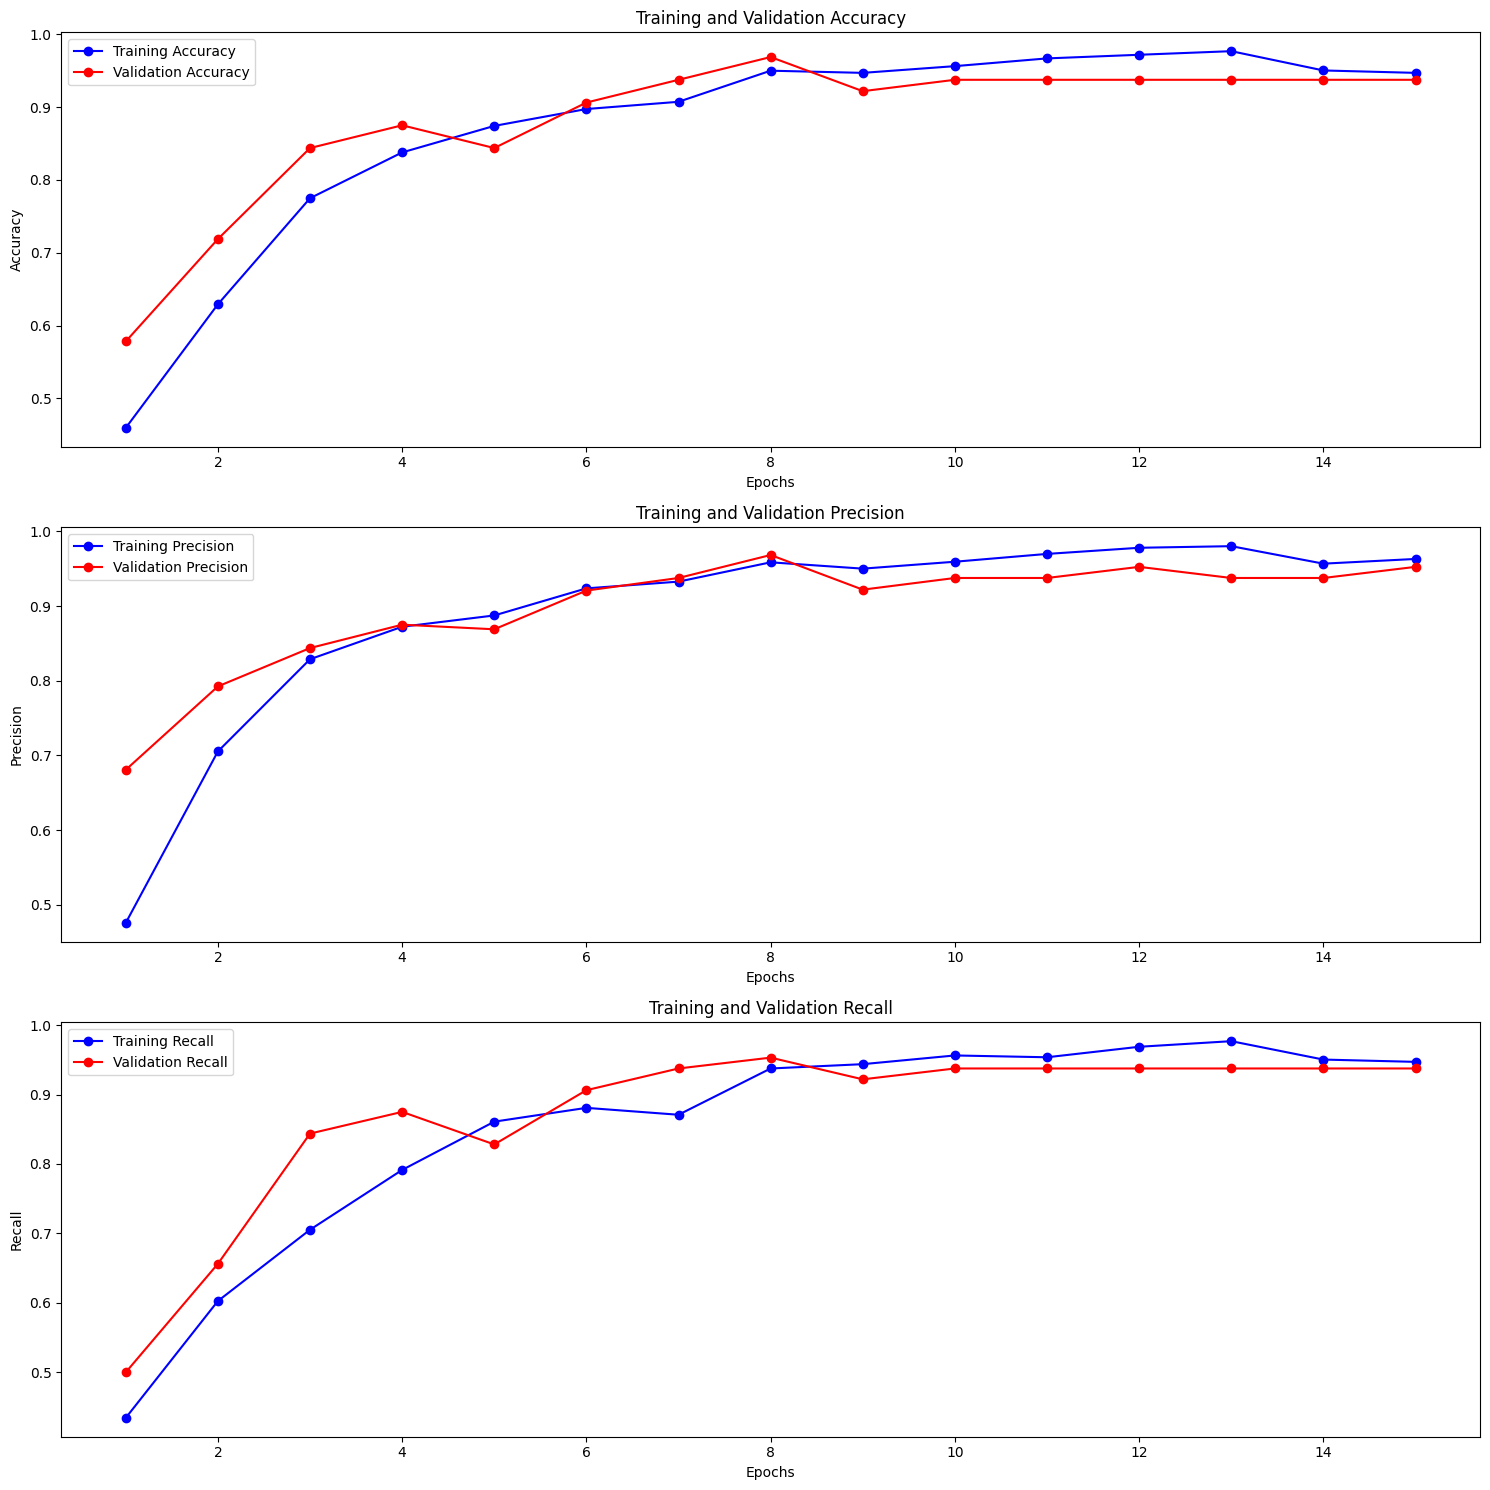

In [ ]:
# Extract the metrics from the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

# Number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(3, 1, 2)
plt.plot(epochs, precision, 'bo-', label='Training Precision')
plt.plot(epochs, val_precision, 'ro-', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(3, 1, 3)
plt.plot(epochs, recall, 'bo-', label='Training Recall')
plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Save the model
model.save('VGG16_image_classifier.h5')

c:\Users\Josh\source\repos\ProjectServer\Josh-main\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model on the testing data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

3/3 [==============================] - 46s 12s/step - loss: 0.5849 - accuracy: 0.9167 - precision: 0.9277 - recall: 0.9167
Test loss: 0.5848907828330994
Test accuracy: 0.9166666865348816
Test precision: 0.9277108311653137
Test recall: 0.9166666865348816
